In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In einem erste Schritt arbeite ich mit den Werten ohne den Zusatz aus dem Feature Engineering.

In [3]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks NLP/data/Total_AlyMan.csv')
df.shape

(5841, 2)

In [4]:
df.head(2)

,Kennzeichen,Beispiel
0,BA,Erkennungsobjekt für elektrisches Potential
1,BA,Objekt zur Erkennung von elektrischem Potential


In [5]:
# Label distribution
df["Kennzeichen"].value_counts(dropna=False)

UL     69
PG     43
UB     34
BG     34
UM     31
       ..
MZ      1
HZ      1
FZ      1
EF      1
WG_     1
Name: Kennzeichen, Length: 946, dtype: int64

Es sind 946 Klassen was sehr schwierig sein dürfte, wie bereits in der Analyse festgestellt wurde hat es viele Klassen mit nur einem Eintrag. Daher soll in einem ersten Schritt nur Labels verwendet werden in denne min 5 Einträge sind. Weiter sollen nur die Hauptklassen verwendet werden sprich die Klassen werden auf die ersten zwei Buchstaben im Kürzel getrimmt. Da die Norm hirarchisch aufgebaut ist bleibt die Funktion bestehen.

In [6]:
dfs = df
# Trimm the Label to the basic ones
dfs["Kennzeichen"] = dfs["Kennzeichen"].str.slice(start=0, stop=1)
# Label distibution
dfs["Kennzeichen"].value_counts(dropna=False).count()

22

In [7]:
# Remove rows, where the label is present only min_labelEntrys
min_labelEntrys = 5
dfs = df.groupby('Kennzeichen').filter(lambda x : len(x) >= min_labelEntrys)
dfs.shape

(5835, 2)

In [8]:
# Label distribution
dfs["Kennzeichen"].value_counts(dropna=False)

B    1066
U     536
E     414
F     412
C     380
X     326
W     314
H     281
G     279
R     272
P     266
T     250
Q     242
K     163
M     149
N     147
S     139
A     104
D      95
Name: Kennzeichen, dtype: int64

In [9]:
dfs.shape

(5835, 2)

Nun sind es noch 177 Klassen, damit mache ich den Versuch ein Modell zu trainieren.

In [10]:
import pandas as pd
import numpy as np
import concurrent.futures

import re
import nltk
import spacy
import matplotlib.pyplot as plt

from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import accuracy_score,f1_score

from collections.abc import Iterable
from collections import Counter

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [11]:
# init for lemmatizer
!python -m spacy download de_core_news_md

nlp = spacy.load("de_core_news_md")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-17 07:23:17.752234: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44.4 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


In [12]:
#set stopword and initialize the stemmer
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stopwords = set(stopwords.words("german"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Clean, Tokenizer, Lematizer and Stemming
In einem ersten Schritt bereinige ich die daten, vereinfache sie mit einem Letatizer und bilde damit token. Damit lassen sich weitere Aussagen treffen und erste Modelle trainieren. Die Funktionen sind aus dem Grundkurs NLP.

In [13]:
# Function to clean token
def clean_text(text, keep_punctuation=False):

    RE_TAGS = re.compile(r"<[^>]+>")
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    
    # remove any html tags (< /br> often found)
    text = re.sub(RE_TAGS, " ", text)
    
    if keep_punctuation:
        RE_ASCII_PUNCTUATION = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR_PUNCTUATION = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)
    
        # keep only ASCII + European Chars and whitespace, no digits, keep punctuation
        text = re.sub(RE_ASCII_PUNCTUATION, " ", text)
        # convert all whitespaces (tabs etc.) to single wspace, keep punctuation
        text = re.sub(RE_SINGLECHAR_PUNCTUATION, " ", text)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
        
        # keep only ASCII + European Chars and whitespace, no digits, no punctuation
        text = re.sub(RE_ASCII, " ", text)
        # convert all whitespaces (tabs etc.) to single wspace
        text = re.sub(RE_SINGLECHAR, " ", text)     
    
    text = re.sub(RE_WSPACE, " ", text)
    
    return text.lower()

In [14]:
def tokenize(text, stopwords):
    """Tokenizes and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
        
    Returns
    -------
    list
        The tokenized text
    """
    
    if isinstance(text, str):
        word_tokens = word_tokenize(text)
    elif isinstance(text, Iterable):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))
    word_tokens = [word.lower() for word in word_tokens if word.lower() not in stopwords]
    
    return word_tokens  

In [15]:
def tokenize_lemma(text, stopwords, lemmanizer, keep_ners=False):
    """Tokenizes, lowercases and lemmatizes a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline)
    keep_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The tokenized and lemmatized text
    """
        
    if isinstance(text, str):
        text = text
    elif isinstance(text, Iterable):
#        print("no join_tokens function!")
        #from fhnw.nlp.utils.text import join_tokens
        #text = join_tokens(text, set())
        text = ' '.join(text)
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))  
    
    if keep_ners:
        # HanoverTagger could be an alternative but takes longer 
        # see: https://textmining.wp.hs-hannover.de/Preprocessing.html#Lemmatisierung-und-Wortarterkennung
        doc = lemmanizer(text, disable=['tagger', 'parser'])

        tokens = list()
        ner_idx = 0
        tok_idx = 0

        # keep ner in one token
        while tok_idx < len(doc):
            if ner_idx >= len(doc.ents) or doc[tok_idx].idx < doc.ents[ner_idx].start_char:
                if doc[tok_idx].is_alpha and not doc[tok_idx].is_punct and doc[tok_idx].text.lower() not in stopwords and doc[tok_idx].lemma_.lower() not in stopwords:
                    #print("token ", doc[tok_idx].lemma_.lower())
                    tokens.append(doc[tok_idx].lemma_.lower())

                tok_idx += 1
            else:
                #print("ner ", doc.ents[ner_idx].lemma_.lower())
                tokens.append(doc.ents[ner_idx].lemma_.lower())

                tok_idx += 1
                while tok_idx < len(doc) and doc[tok_idx].idx < doc.ents[ner_idx].end_char:
                    tok_idx += 1

                ner_idx += 1

        return tokens
    else:
        doc = lemmanizer(text, disable=['tagger', 'parser', 'ner']) 
        return [tok.lemma_.lower() for tok in doc if tok.is_alpha and not tok.is_punct and tok.text.lower() not in stopwords and tok.lemma_.lower() not in stopwords]

In [16]:
def tokenize_stem(text, stopwords, stemmer):
    """Tokenizes, lowercases and stems a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer)
        
    Returns
    -------
    list
        The tokenized and stemmed text
    """
        
    if isinstance(text, str):
        word_tokens = word_tokenize(text)
    elif isinstance(text, Iterable):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))
    
    word_tokens = [stemmer.stem(word.lower()) for word in word_tokens if word.lower() not in stopwords]

    return word_tokens

In [17]:
def normalize(text, stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False):
    """Normalizes (e.g. tokenize and stem) and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer) or None to disable stemming
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline) or None to disable lemmantization
    lemma_with_ner: bool
        Defines if named entities (NERs) should be keept in one token
        
    Returns
    -------
    list
        The normalized text
    """
        
    if lemmanizer is not None:
        return tokenize_lemma(text, stopwords, lemmanizer, keep_ners=lemma_with_ner)
    elif stemmer is not None:
        return tokenize_stem(text, stopwords, stemmer)
    else:
        return tokenize(text, stopwords)

In [18]:
#create clean token
dfs['token_clean'] =  dfs.apply(lambda row: normalize(clean_text(row.Beispiel), stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False), axis=1)
dfs.head(4)

,Kennzeichen,Beispiel,token_clean
0,B,Erkennungsobjekt für elektrisches Potential,"[erkennungsobjekt, elektrisches, potential]"
1,B,Objekt zur Erkennung von elektrischem Potential,"[objekt, erkennung, elektrischem, potential]"
2,B,Kopplungskondensator,[kopplungskondensator]
3,B,Messspannungsrelais,[messspannungsrelais]


In [19]:
#lemmatize the token
dfs['token_lemma'] = dfs.apply(lambda row: normalize(row.token_clean, stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False), axis=1)

In [20]:
dfs.head(4)

,Kennzeichen,Beispiel,token_clean,token_lemma
0,B,Erkennungsobjekt für elektrisches Potential,"[erkennungsobjekt, elektrisches, potential]","[erkennungsobjekt, elektrisch, potential]"
1,B,Objekt zur Erkennung von elektrischem Potential,"[objekt, erkennung, elektrischem, potential]","[objekt, erkennung, elektrisch, potential]"
2,B,Kopplungskondensator,[kopplungskondensator],[kopplungskondensator]
3,B,Messspannungsrelais,[messspannungsrelais],[messspannungsrelai]


### n-gram analyze
Nun da die Inhalte aufbereitet sind können damit n-grams gebildet werde und diese dann analysiert werden.

In [21]:
def create_ngram_counts(df, n = 2, field_read="token_lemma"):
    """Creates the n-gram counts of a column of text tokens

    Parameters
    ----------
    df : dataframe
        The dataframe
    n : int
        The n grams to create (e.g. 2 for bi-gram)
    field_read : str
        The column name to read from (default is token_lemma)
        
    Returns
    -------
    Counter
        The n-gram counts
    """
    
    counter = Counter()

    #_ = df[field_read].apply(lambda x: counter.update(nltk.ngrams(x, n)))
    #_ = df[field_read].apply(lambda x: counter.update([" ".join(grams) for grams in nltk.ngrams(x, n)]))
    _ = df[field_read].apply(lambda x: counter.update([" ".join(x[i:i+n]) for i in range(len(x)-n+1)]))

    
    return counter

In [22]:
def plot_ngram_counts(counter, n_most_common, title="Term frequencies"):
    """Plots the n-gram counts

    Parameters
    ----------
    counter : Counter
        The counter of the n-grams
    n_most_common : int
        The n most common n-grams to plog
    title : str
        The title of the plot
    """        
    y = [count for tag, count in counter.most_common(n_most_common)]
    x = [tag for tag, count in counter.most_common(n_most_common)]

    plt.bar(x, y)
    plt.title(title)
    plt.ylabel("Frequency")
    #plt.yscale('log') # set log scale for y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(counter.most_common(n_most_common)):
        plt.text(i, count, f' {count} ', rotation=90, ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

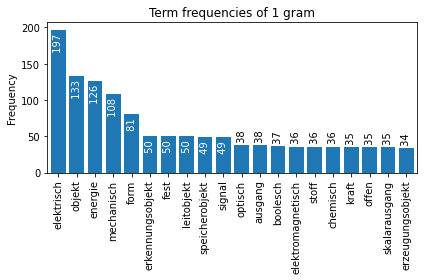

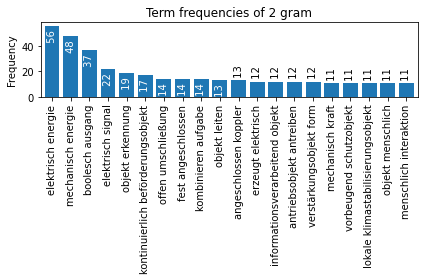

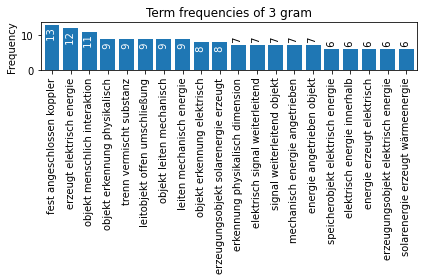

In [23]:
ngrams_1 = create_ngram_counts(dfs, 1)
ngrams_2 = create_ngram_counts(dfs, 2)
ngrams_3 = create_ngram_counts(dfs, 3)

plot_ngram_counts(ngrams_1, 20, "Term frequencies of 1 gram")
plot_ngram_counts(ngrams_2, 20, "Term frequencies of 2 gram")
plot_ngram_counts(ngrams_3, 20, "Term frequencies of 3 gram")

Die Analyse zeigt die meist auftretenden Wörter. Das Ergebniss macht absolut Sinn da das Dokument in erster Linie elektrische Komponenten bedient.

### k-nearest neighbors
Das erste einfache Modell kann trainiert werden, in diesem Fall wird ein k-nearest neighbors verwendet.

In [24]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix, hstack , vstack

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable

import numpy as np

In [25]:
dfk = dfs
dfk.shape

(5835, 4)

In [26]:
dfk.head(3)

,Kennzeichen,Beispiel,token_clean,token_lemma
0,B,Erkennungsobjekt für elektrisches Potential,"[erkennungsobjekt, elektrisches, potential]","[erkennungsobjekt, elektrisch, potential]"
1,B,Objekt zur Erkennung von elektrischem Potential,"[objekt, erkennung, elektrischem, potential]","[objekt, erkennung, elektrisch, potential]"
2,B,Kopplungskondensator,[kopplungskondensator],[kopplungskondensator]


In [27]:
dfk['str_lemma'] = dfk.apply(lambda row: ' '.join(row.token_lemma), axis=1)
dfk.head(2)

,Kennzeichen,Beispiel,token_clean,token_lemma,str_lemma
0,B,Erkennungsobjekt für elektrisches Potential,"[erkennungsobjekt, elektrisches, potential]","[erkennungsobjekt, elektrisch, potential]",erkennungsobjekt elektrisch potential
1,B,Objekt zur Erkennung von elektrischem Potential,"[objekt, erkennung, elektrischem, potential]","[objekt, erkennung, elektrisch, potential]",objekt erkennung elektrisch potential


In [28]:
dfk_X = pd.get_dummies(dfk.str_lemma)
dfk_y = pd.get_dummies(dfk.Kennzeichen)
dfk_X.head(2)

,-- werkstatt,abdeckblech,abdeckungsobjekt abschließen objekt,abdeckungsobjekt abschlussstrukturen,abdeckungsobjekt schließen öffnung,abdeckungsobjekt verdeck fug übergängen,abdichtungsmittel,abfallanlagenschacht,abfallbehälterraum,abfallbereich,...,überwachungsgerät seismisch schwingung,überwachungskameras,überwachungsraum,übungslabor,übungsraum,übungsraum ausüben künstlerisch aktivität,übungsraum kind,übungsraum sportlich aktivität,übungsraum trainieren kraft kondition balance,übungsraum üben künstlerisch fähigkeit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(dfk_X, dfk_y,
                                                    stratify=dfk_y, 
                                                    test_size=0.25,
                                                   random_state=2)

In [30]:
# fit a k-nearest neighbor model to the data
K = 2
model = KNeighborsClassifier(n_neighbors = K)
model.fit(X_train, y_train)
print(model)

KNeighborsClassifier(n_neighbors=2)


In [31]:
y_pred = model.predict(X_test)

In [32]:
f1_score(y_test, y_pred, average="weighted")

0.15960502948602748

In [33]:
# defining parameter range 
param_grid = {'p': [1, 2, 3],  
              'n_neighbors': [2,3,4,5]}  
   
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 

In [34]:
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5], 'p': [1, 2, 3]},
             verbose=3)

In [35]:
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 

{'n_neighbors': 3, 'p': 1}


In [36]:
# evaluate the performance of model with the Best parameters on testing set
knn = KNeighborsClassifier(p=1, n_neighbors=3)
knn_best_model = knn.fit(X_train, y_train)
print("Best Model Testing Score: ", f1_score(y_test, y_pred, average="weighted"))

Best Model Testing Score:  0.15960502948602748


Das Ergebnis ist sehr überschaulich respektive zeigt es das mit dem gewählten Modell die Problemstellung nicht gelöst werden kann.

# Auswertung der Featureengineering Daten
Um das Modell zu verbessern werden die Daten welche mit zusätzlichem Inhalt aus Wikipedia ergänzt wurden verwendet.

In [48]:
dfs = pd.read_csv('drive/MyDrive/Colab Notebooks NLP/data/Total_FEN.csv')

In [49]:
# Trimm the Label to the basic ones
dfs["Kennzeichen"] = dfs["Kennzeichen"].str.slice(start=0, stop=1)
# Label distibution
dfs["Kennzeichen"].value_counts(dropna=False).count()

22

In [50]:
# Remove rows, where the label is present only min_labelEntrys
min_labelEntrys = 5
dfs = df.groupby('Kennzeichen').filter(lambda x : len(x) >= min_labelEntrys)

In [51]:
#create clean token
dfs['token_clean'] =  dfs.apply(lambda row: normalize(clean_text(row.Beispiel), stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False), axis=1)
#lemmatize the token
dfs['token_lemma'] = dfs.apply(lambda row: normalize(row.token_clean, stopwords, stemmer=None, lemmanizer=nlp, lemma_with_ner=False), axis=1)

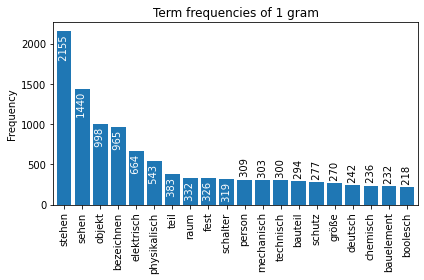

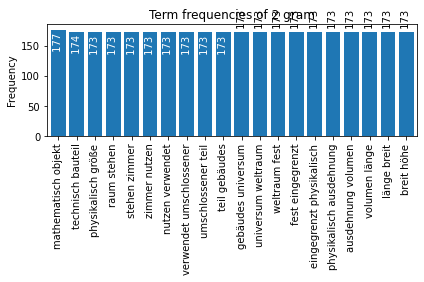

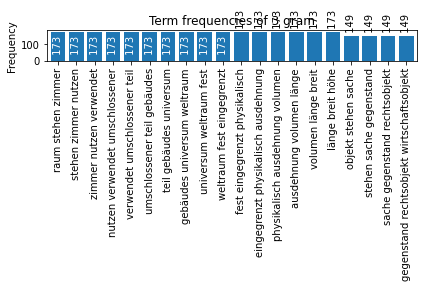

In [52]:
ngrams_1 = create_ngram_counts(dfs, 1)
ngrams_2 = create_ngram_counts(dfs, 2)
ngrams_3 = create_ngram_counts(dfs, 3)

plot_ngram_counts(ngrams_1, 20, "Term frequencies of 1 gram")
plot_ngram_counts(ngrams_2, 20, "Term frequencies of 2 gram")
plot_ngram_counts(ngrams_3, 20, "Term frequencies of 3 gram")

In [53]:
dfk = dfs
dfk['str_lemma'] = dfk.apply(lambda row: ' '.join(row.token_lemma), axis=1)
dfk.head(2)

,Kennzeichen,Beispiel,token_clean,token_lemma,str_lemma
0,BA,Erkennungsobjekt für elektrisches Potential,"[erkennungsobjekt, elektrisches, potential]","[erkennungsobjekt, elektrisch, potential]",erkennungsobjekt elektrisch potential
1,BA,Objekt zur Erkennung von elektrischem Potential,"[objekt, erkennung, elektrischem, potential]","[objekt, erkennung, elektrisch, potential]",objekt erkennung elektrisch potential


In [54]:
dfk_X = pd.get_dummies(dfk.str_lemma)
dfk_y = pd.get_dummies(dfk.Kennzeichen)
dfk_X.head(2)

,,-- stehen ratschlag empfehlung beratend beschlussfassend gremium -- europäisch union offiziell kurzbezeichnung eu ministerrats -- -- bzw aal stehen europäisch aal europa vorkommend art anguilla anguilla gattung familie anguilla anguillidae sehen aal ordnung anguilliform knochenfisch sehen,-- werkstatt,abdeckblech,abdeckungsobjekt abschließen objekt,abdeckungsobjekt abschlussstrukturen,abdeckungsobjekt schließen öffnung,abdeckungsobjekt verdeck fug übergängen,abdichtungsmittel,abfall bzw,...,überwachungsgerät seismisch schwingung,überwachungskameras,überwachungsraum,übungslabor,übungsraum,übungsraum ausüben künstlerisch aktivität,übungsraum kind,übungsraum sportlich aktivität,übungsraum trainieren kraft kondition balance,übungsraum üben künstlerisch fähigkeit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(dfk_X, dfk_y,
                                                    stratify=dfk_y, 
                                                    test_size=0.25,
                                                   random_state=2)

In [56]:
# fit a k-nearest neighbor model to the data
K = 3
p = 1
model = KNeighborsClassifier(p=p, n_neighbors = K)
model.fit(X_train, y_train)
print(model)

KNeighborsClassifier(n_neighbors=3, p=1)


In [57]:
y_pred = model.predict(X_test)

In [58]:
f1_score(y_test, y_pred, average="weighted")

0.0077358955407735895

Das Ergebniss des Modell konnte nicht weiter verbessert werden. In einem nächsten Schritt soll ein Transformer Modell eingesetzt werden.